/var/folders/6g/6nvgb32d03dd7z1f9qv97qnw0000gn/T/ipykernel_19931/1795321750.py:17: DtypeWarning: Columns (12,13,15,16,22,23,30,33,34,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,61,63,65) have mixed types. Specify dtype option on import or set low_memory=False.
  processing_train = pd.read_csv('./data/train/processing_train.csv')


<class 'pandas.core.frame.DataFrame'>
Index: 5276 entries, 58 to 22086
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   受注番号    5276 non-null   object 
 1   号機名     5276 non-null   object 
 2   作業日     5276 non-null   object 
 3   数量1     5276 non-null   float64
 4   作業時間    5276 non-null   int64  
 5   合計時間    5276 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 288.5+ KB
正味作業時間のMAE: 9.952812099542406
付帯作業時間のMAE: 18.545428869543073


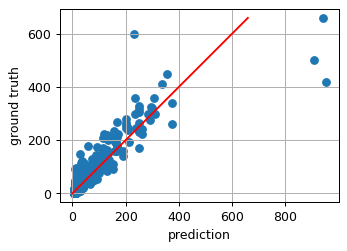

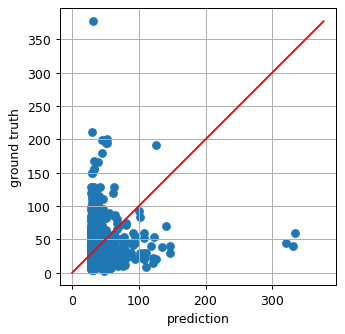

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   5983 non-null   int64  
 1   受注番号    5983 non-null   object 
 2   号機名     5983 non-null   object 
 3   数量1     5983 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 187.1+ KB


,index,正味作業時間,付帯作業時間
0,0,14.871323,30.923267
1,1,36.984899,38.072170
2,2,18.556919,32.114750
3,3,18.556919,32.114750
4,4,11.799993,29.930363
...,...,...,...
5978,5978,9.650062,29.235331
5979,5979,11.185727,29.731783
5980,5980,13.642791,30.526105
5981,5981,23.471047,33.703396


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# # 基本データ
# base_train = pd.read_csv('./data/train/base_train.csv')
# base_train
# base_train['受注日'] = pd.to_datetime(base_train['受注日'], format='mixed')
# 
# # キャンセルデータを排除
# cond1 = base_train.受注キャンセルフラグ!=1
# base = base_train[cond1]
# base
# ## キャンセル 3023レコード
# 

# 加工データ
processing_train = pd.read_csv('./data/train/processing_train.csv')
processing_train

# 作業実績データ
actual_train = pd.read_csv('./data/train/actual_train.csv')
actual_train

# 実績データから意味あるデータを抽出
# actual_train['作業日'] = pd.to_datetime(actual_train['作業日'])
# actual_filtered = actual_train[actual_train['号機名'].isin(['グルアー','2号機','4号機','6号機','7号機','8号機'])]
# actual_filtered = actual_filtered[actual_filtered['作業日']>='2020-02-04']
# actual_filtered = actual_filtered[(actual_filtered['作業時間']>0)&(actual_filtered['合計時間']>0)]
# 
# plt.hist(actual_filtered['作業時間'], bins=100)
# plt.show()
# 
# actual_filtered[['作業時間','合計時間']].describe()


train_merged = pd.merge(processing_train, actual_train, on = ['受注番号','号機名'])
train_merged = train_merged[train_merged['作業日']>='2020-02-04']
train_data = train_merged[['受注番号', '号機名', '作業日','数量1', '作業時間', '合計時間']]
train_data = train_data[train_data['号機名'].isin(['グルアー','2号機','4号機','6号機','7号機','8号機'])]
train_data = train_data[(train_data['作業時間']>0)&(train_data['合計時間']>0)]
# train_data.info()
train_data['数量1'] = train_data['数量1'].astype(float)
train_data.info()

from sklearn import linear_model

regr = linear_model.LinearRegression()

train_all = train_data[train_data['作業日']<'2020-06-01']
val_all = train_data[train_data['作業日']>='2020-06-01']

regr.fit(train_all[['数量1']], train_all[['作業時間', '合計時間']])

import numpy as np

y_hat = regr.predict(val_all[['数量1']])
print('正味作業時間のMAE:', np.abs(val_all['作業時間']-y_hat[:,0]).mean())
print('付帯作業時間のMAE:', np.abs(val_all['合計時間']-y_hat[:,1]).mean())

# 正味作業時間
fig, ax = plt.subplots(figsize=(4, 4), dpi=90)
ax.set_xlabel('prediction', fontsize=10)
ax.set_ylabel('ground truth', fontsize=10)
ax.set_yscale("linear")
ax.plot([i for i in range(int(val_all['作業時間'].max()))],[i for i in range(int(val_all['作業時間'].max()))], color='red')
ax.scatter(y_hat[:,0], val_all['作業時間'])
ax.grid()
ax.set_aspect('equal')
plt.show()

# 付帯作業時間
fig, ax = plt.subplots(figsize=(4, 4), dpi=90)
ax.set_xlabel('prediction', fontsize=10)
ax.set_ylabel('ground truth', fontsize=10)
ax.set_yscale("linear")
ax.plot([i for i in range(int(val_all['合計時間'].max()))],[i for i in range(int(val_all['合計時間'].max()))], color='red')
ax.scatter(y_hat[:,1], val_all['合計時間'])
ax.grid()
ax.set_aspect('equal')
plt.show()


processing_test = pd.read_csv('./data/test/processing_test.csv')
actual_test = pd.read_csv('./data/test/actual_test.csv')
test_merged = pd.merge(actual_test, processing_test)
test_data = test_merged[['index','受注番号','号機名','数量1']]
test_data.info()

y_hat = regr.predict(test_data[['数量1']])

submit = pd.DataFrame({'index':test_data['index'], '正味作業時間':y_hat[:,0], '付帯作業時間':y_hat[:,1]})
submit

submit.to_csv('./data/20230919_1_submission.csv', index=None, header=False)